This Notebook was used to implent and test different models on our network.

In [1]:
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random
import matplotlib.animation as animation


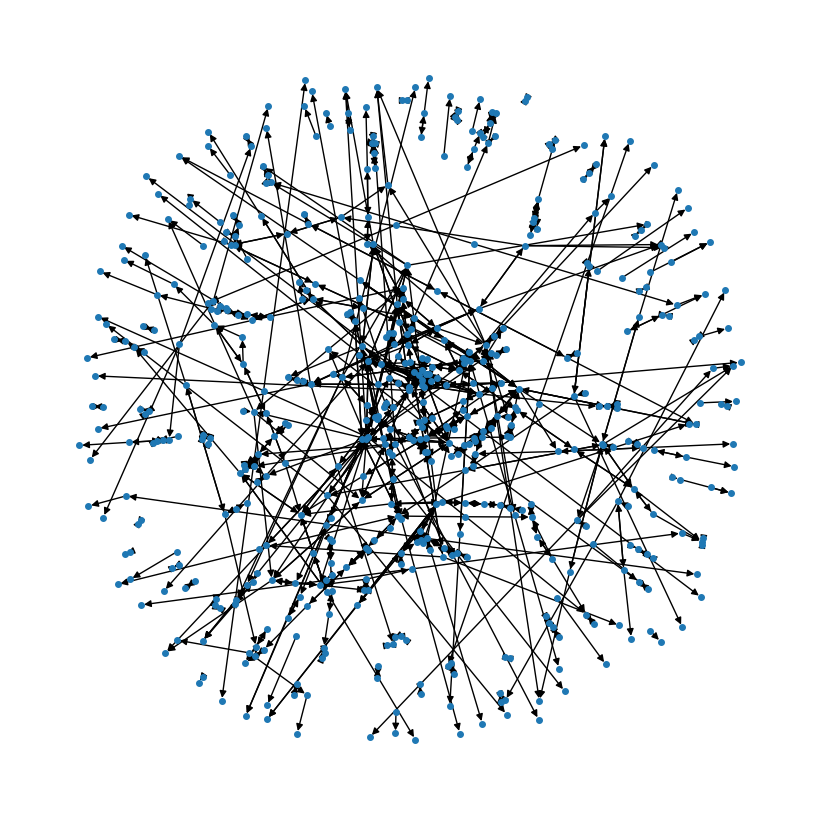

In [2]:
G = pd.read_csv('calls.csv')
G = nx.from_pandas_edgelist(G, 'caller', 'callee', ['duration', 'timestamp'], create_using=nx.DiGraph())
G.remove_edges_from(nx.selfloop_edges(G))
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
threshold = 0.5
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get("weight", 1) < threshold]
G.remove_edges_from(edges_to_remove)
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=16)
plt.show()

In [3]:
degrees = [d for _, d in G.degree()]
degree_counts = Counter(degrees)
k, freq = zip(*degree_counts.items())
total_nodes = G.number_of_nodes()
pk = [f / total_nodes for f in freq]

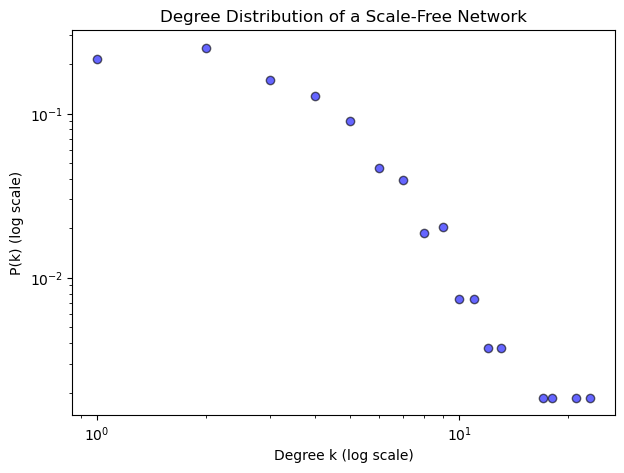

In [4]:
plt.figure(figsize=(7,5))
plt.scatter(k, pk, color="blue", alpha=0.6, edgecolors="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k (log scale)")
plt.ylabel("P(k) (log scale)")
plt.title("Degree Distribution of a Scale-Free Network")
plt.show()


In [5]:
log_k = np.log(np.array(k))
log_pk = np.log(np.array(pk))
slope, intercept = np.polyfit(log_k, log_pk, 1)
gamma = -slope

print(f"Estimated power-law exponent γ ≈ {gamma:.2f}")

Estimated power-law exponent γ ≈ 1.99


In [6]:
fit = powerlaw.Fit(degrees, discrete=True)
print(f"Estimated alpha (exponent): {fit.alpha:.2f}")
print(f"Estimated xmin (cutoff): {fit.xmin}")

Calculating best minimal value for power law fit
Estimated alpha (exponent): 4.21
Estimated xmin (cutoff): 7.0


In [7]:
print(f"KS statistic: {fit.D:.4f}")

KS statistic: 0.0405


In [8]:
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio (R): {R:.2f}, p-value: {p:.4f}")

Loglikelihood ratio (R): -0.17, p-value: 0.6790


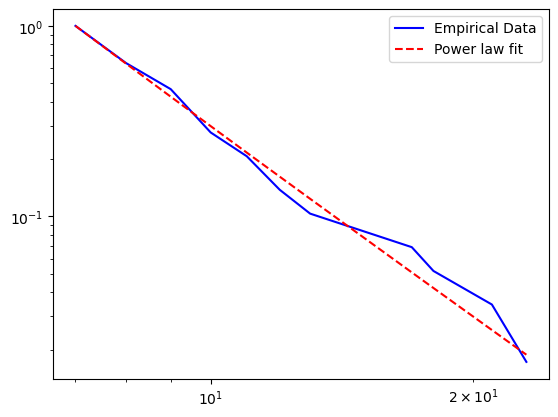

In [9]:
fig = fit.plot_ccdf(color='b', label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
plt.legend()
plt.show()

SIR Model (Susceptible → Infected → Recovered)
- States:
- S: Susceptible
- I: Infected
- R: Recovered (or Removed)
- Transitions:
- Recovered nodes cannot be reinfected — they are immune or removed.
- Use case:
- One-time infections or permanently rejected beliefs.
- Key trait:
- Epidemic eventually dies out.
- Permanent immunity.

Function to get the Largest Neighbourhood

In [10]:
def get_largest_component(G):
    """
    Returns the largest connected component subgraph.
    Works for both directed and undirected graphs.
    """
    if G.is_directed():
        # Use weakly connected components for spread (ignores direction)
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()

Function to simulate the spread of a Hoax

In [11]:
def simulate_hoax(G, beta=0.3, gamma=0.05, steps=50):
    """
    Simulates hoax spread on graph G using an SIR-like model.
    beta = infection probability
    gamma = recovery probability
    steps = number of iterations
    """
    # Extract largest component
    G_lcc = get_largest_component(G)

    # Initialize states: 0=S, 1=I, 2=R
    state = {n: 0 for n in G_lcc.nodes()}

    # Infect a hub (highest degree node)
    hub = max(G_lcc.degree, key=lambda x: x[1])[0]
    state[hub] = 1

    # Track counts
    S, I, R = [], [], []

    for t in range(steps):
        new_state = state.copy()
        for node in G_lcc.nodes():
            if state[node] == 1:  # infected
                # Try to infect neighbors
                for neigh in G_lcc.neighbors(node):
                    if state[neigh] == 0 and random.random() < beta:
                        new_state[neigh] = 1
                # Recovery
                if random.random() < gamma:
                    new_state[node] = 2
        state = new_state

        # Count states
        S.append(sum(1 for v in state.values() if v == 0))
        I.append(sum(1 for v in state.values() if v == 1))
        R.append(sum(1 for v in state.values() if v == 2))

    return S, I, R



Plotting section

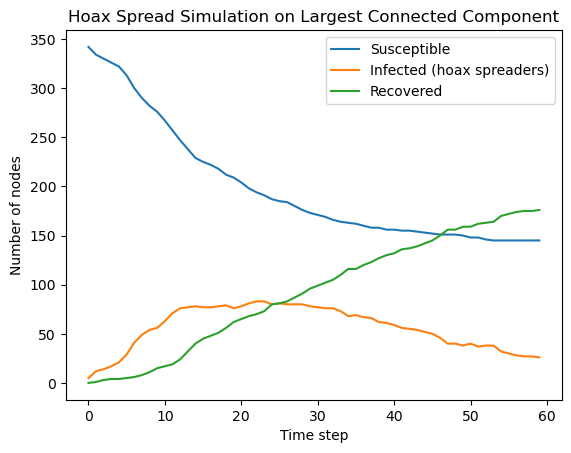

In [12]:
S, I, R = simulate_hoax(G, beta=0.3, gamma=0.05, steps=60)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected (hoax spreaders)")
plt.plot(R, label="Recovered")
plt.xlabel("Time step")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("Hoax Spread Simulation on Largest Connected Component")
plt.show()


SIC Model (Susceptible → Infected → Carrier)
- States:
- S: Susceptible
- I: Infected (actively spreading)
- C: Carrier (no longer symptomatic but still infectious)
- Transitions:
- Infected nodes become carriers, who continue to spread but don’t change state further.
- Use case:
- Persistent misinformation or asymptomatic transmission.
- Key trait:
- Carriers sustain long-term spread.
- No recovery or immunity.

Testing the carrier component

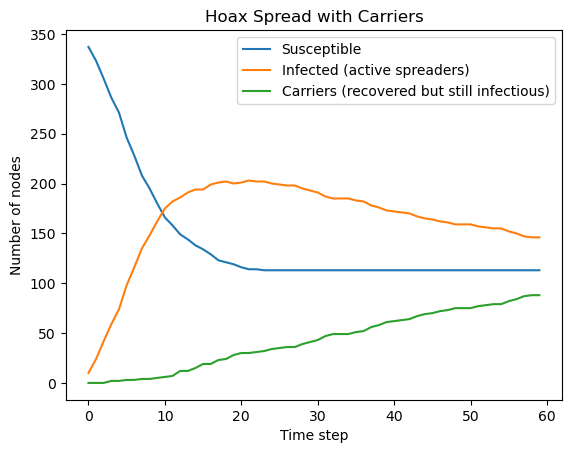

In [13]:
def simulate_hoax_with_carriers(G, beta=0.3, gamma=0.05, steps=50):
    # Extract largest component
    if G.is_directed():
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    # States: 0=S, 1=I, 2=C (carrier)
    state = {n: 0 for n in G_lcc.nodes()}
    hub = max(G_lcc.degree, key=lambda x: x[1])[0]
    state[hub] = 1

    S, I, C = [], [], []

    for t in range(steps):
        new_state = state.copy()
        for node in G_lcc.nodes():
            if state[node] in [1, 2]:  # infected or carrier
                for neigh in G_lcc.neighbors(node):
                    if state[neigh] == 0 and random.random() < beta:
                        new_state[neigh] = 1
            if state[node] == 1:  # infected can become carrier
                if random.random() < gamma:
                    new_state[node] = 2
        state = new_state

        S.append(sum(1 for v in state.values() if v == 0))
        I.append(sum(1 for v in state.values() if v == 1))
        C.append(sum(1 for v in state.values() if v == 2))

    return S, I, C

S, I, C = simulate_hoax_with_carriers(G, beta=0.5, gamma=0.01, steps=60)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected (active spreaders)")
plt.plot(C, label="Carriers (recovered but still infectious)")
plt.xlabel("Time step")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("Hoax Spread with Carriers")
plt.show()

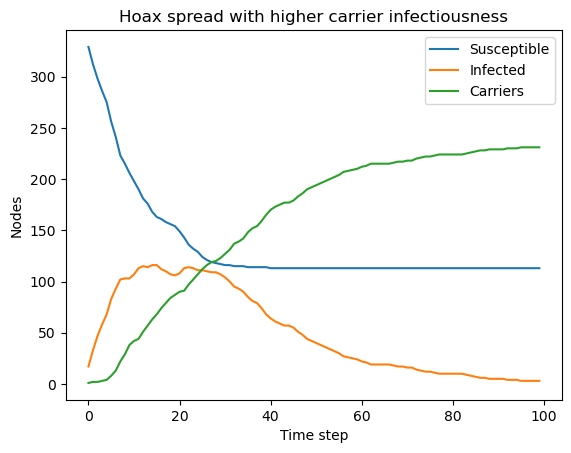

In [14]:
def largest_component(G):
    if G.is_directed():
        comp = max(nx.weakly_connected_components(G), key=len)
    else:
        comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

def simulate_carrier_model(G, beta_I=0.25, beta_C=0.45, gamma=0.05, steps=80, seeds=3):
    """
    States: 0=S, 1=I (infected), 2=C (carrier, not reinfected, still infectious)
    beta_I: infection prob from infected
    beta_C: infection prob from carriers
    gamma: I -> C transition prob
    """
    G = largest_component(G)

    # Seeds: pick high-degree nodes in different regions if possible
    deg_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    initial = [n for n, _ in deg_sorted[:seeds]]
    state = {n: 0 for n in G.nodes()}
    for n in initial:
        state[n] = 1

    S, I, C = [], [], []
    for t in range(steps):
        new_state = state.copy()
        for u in G.nodes():
            # choose infection probability based on state
            if state[u] == 1 or state[u] == 2:
                beta = beta_I if state[u] == 1 else beta_C
                # for directed graphs, use out-neighbors
                neighbors = G.successors(u) if G.is_directed() else G.neighbors(u)
                for v in neighbors:
                    if state[v] == 0 and random.random() < beta:
                        new_state[v] = 1
                # infected become carriers
                if state[u] == 1 and random.random() < gamma:
                    new_state[u] = 2
        state = new_state
        S.append(sum(1 for s in state.values() if s == 0))
        I.append(sum(1 for s in state.values() if s == 1))
        C.append(sum(1 for s in state.values() if s == 2))
    return S, I, C

S, I, C = simulate_carrier_model(G, beta_I=0.25, beta_C=0.45, gamma=0.04, steps=100, seeds=5)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected")
plt.plot(C, label="Carriers")
plt.xlabel("Time step")
plt.ylabel("Nodes")
plt.legend()
plt.title("Hoax spread with higher carrier infectiousness")
plt.show()

SI Model (Susceptible → Infected)
- States:
- S: Susceptible — can be infected.
- I: Infected — actively spreading.
- Transitions:
- Once infected, a node stays infected forever.
- Use case:
- Irreversible spread (e.g., permanent belief adoption, computer viruses).
- Key trait:
- Infection accumulates until saturation.
- No recovery.


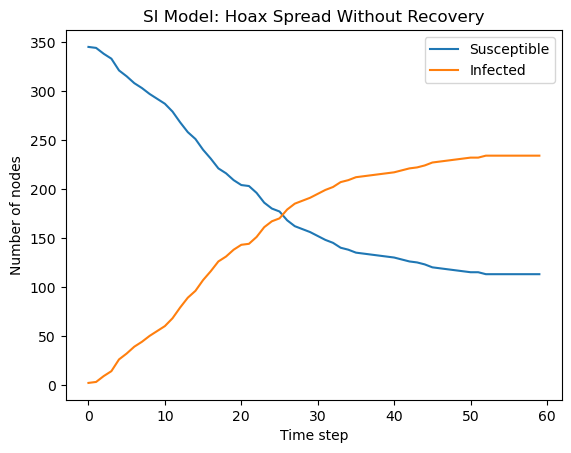

In [15]:
def simulate_si_model(G, beta=0.2, steps=50, seed_count=1):
    # Extract largest connected component
    if G.is_directed():
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    # Initialize states: 0 = Susceptible, 1 = Infected
    state = {n: 0 for n in G_lcc.nodes()}
    # Infect seed nodes (e.g., top-degree hubs)
    seeds = sorted(G_lcc.degree, key=lambda x: x[1], reverse=True)[:seed_count]
    for node, _ in seeds:
        state[node] = 1

    S, I = [], []

    for t in range(steps):
        new_state = state.copy()
        for node in G_lcc.nodes():
            if state[node] == 1:
                neighbors = G_lcc.successors(node) if G_lcc.is_directed() else G_lcc.neighbors(node)
                for neigh in neighbors:
                    if state[neigh] == 0 and random.random() < beta:
                        new_state[neigh] = 1
        state = new_state
        S.append(sum(1 for v in state.values() if v == 0))
        I.append(sum(1 for v in state.values() if v == 1))

    return S, I

S, I = simulate_si_model(G, beta=0.2, steps=60, seed_count=1)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected")
plt.xlabel("Time step")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("SI Model: Hoax Spread Without Recovery")
plt.show()


SIS Model (Susceptible → Infected → Susceptible)
- States:
- S: Susceptible
- I: Infected
- Transitions:
- Infected nodes recover and return to susceptible.
- Use case:
- Recurring infections or beliefs that fade and return (e.g., seasonal flu, rumors).
- Key trait:
- Infection can persist indefinitely.
- No immunity.

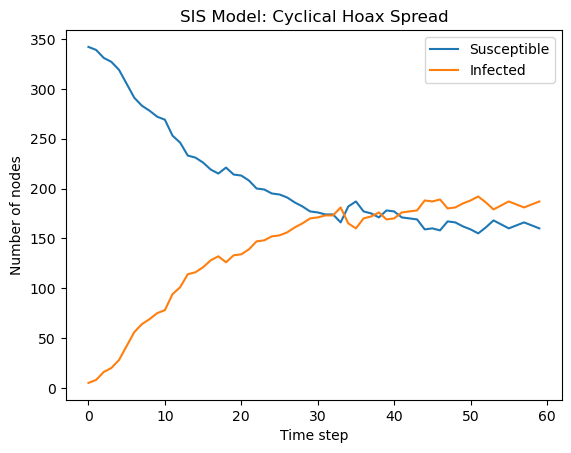

In [16]:
def simulate_sis_model(G, beta=0.3, gamma=0.1, steps=60, seed_count=1):
    # Extract largest connected component
    if G.is_directed():
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    # Initialize states: 0 = Susceptible, 1 = Infected
    state = {n: 0 for n in G_lcc.nodes()}
    seeds = sorted(G_lcc.degree, key=lambda x: x[1], reverse=True)[:seed_count]
    for node, _ in seeds:
        state[node] = 1

    S, I = [], []

    for t in range(steps):
        new_state = state.copy()
        for node in G_lcc.nodes():
            if state[node] == 1:
                neighbors = G_lcc.successors(node) if G_lcc.is_directed() else G_lcc.neighbors(node)
                for neigh in neighbors:
                    if state[neigh] == 0 and random.random() < beta:
                        new_state[neigh] = 1
                # Recovery
                if random.random() < gamma:
                    new_state[node] = 0
        state = new_state
        S.append(sum(1 for v in state.values() if v == 0))
        I.append(sum(1 for v in state.values() if v == 1))

    return S, I

S, I = simulate_sis_model(G, beta=0.3, gamma=0.1, steps=60, seed_count=1)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected")
plt.xlabel("Time step")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("SIS Model: Cyclical Hoax Spread")
plt.show()